In [39]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [40]:
df = pd.read_csv("forecasting_data.csv")
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


## 1. Visualize and interprete the pattern of this time-series

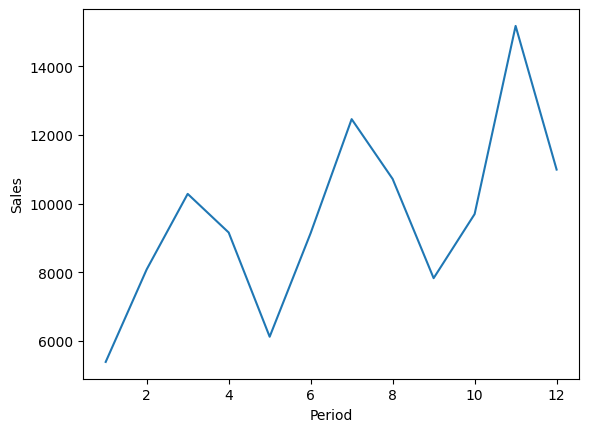

In [41]:
plt.plot(df['Period'], df['Sales'])
plt.xlabel('Period')
plt.ylabel('Sales')
plt.show()

## 2. Predict future demand in the four next quarters without seasonality

### Using moving average

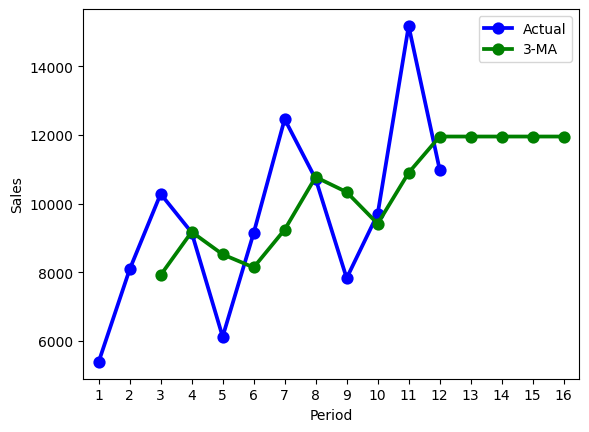

In [42]:
# Using moving average
def moving_average(df, k, to_period):
    # Had to adjust initial implementation
    moving_average_df = pd.DataFrame({
        'Period': range(1, to_period + 1),
        'Sales': [None] * to_period
    })
    for i in range(1, len(df) + 1):
        if i >= k:
            moving_average_df.at[i-1, 'Sales'] = df['Sales'][i-k:i].mean()
    last_k_averages = df['Sales'][-k:].mean()
    for j in range(len(df), to_period):
        moving_average_df.at[j, 'Sales'] = last_k_averages
    
    return moving_average_df

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])
plt.show()

### Using exponential smoothing

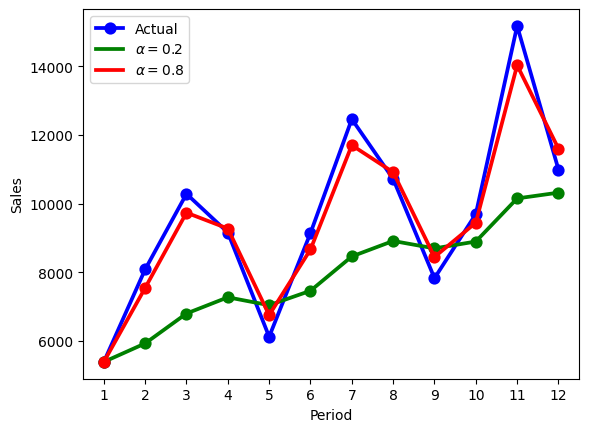

In [43]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df['Period'] = df['Period']
    es_df['Sales'] = None
    es_df.at[0, 'Sales'] = df['Sales'][0]
    for i in range(1, len(df)):
        es_df.at[i, 'Sales'] = alpha * df['Sales'][i] + (1 - alpha) * es_df['Sales'][i-1]
    return es_df

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

## 3. Predict future demand in the four next quarters with seasonality

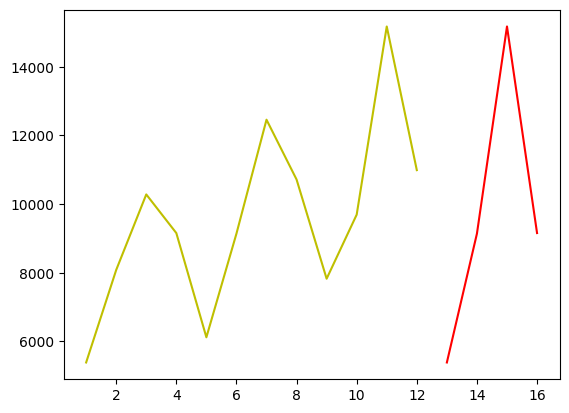

In [44]:
#season function
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
def get_seq(row):
    return row['Period']%4 if row['Period']%4 != 0 else 4

# I essentially had to rewrite this whole function as I am using a newer pandas version and a lot of the functions used in the original implementation are deprecated
# I just found it easier to start again than to try and fix the old code
def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    
    season_df = new_df.pivot_table(index='Seq', columns='Season', values='Sales', aggfunc='mean')
    seasonal_index_df = season_df.div(season_df.mean(axis=0), axis=1)
    
    # Forecast using the seasonal indices
    forecast_list = []
    season_cycle = ['I', 'II', 'III']
    
    for month in months:
        seq = month % 4 if month % 4 != 0 else 4
        season = season_cycle[(seq - 1) % 3]
        sales_forecast = seasonal_index_df.at[seq, season] * season_df.mean(axis=0)[season]
        forecast_list.append({'Period': month, 'Sales': sales_forecast})
    
    forecast_df = pd.DataFrame(forecast_list)
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

# 4.Evaluation: compare the above implemented methods

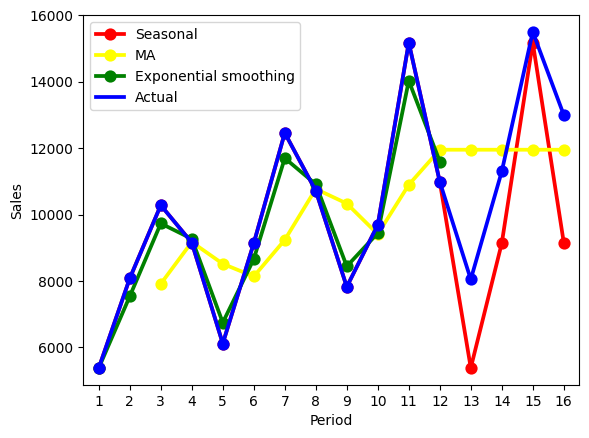

In [45]:
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)

f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()

In [46]:
MAD = np.abs(eval_df['Sales'] - ma_df['Sales']).mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD = np.abs(eval_df['Sales'] - es_df_02['Sales']).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD))
MAD = np.abs(eval_df['Sales'] - es_df_08['Sales']).mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD))
MAD = np.abs(eval_df['Sales'] - season_df['Sales']).mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD))

MAD of 3-MA: 1874.5476190476188
MAD of Exponential smoothing with alpha=0.2: 1942.508575279786
MAD of Exponential smoothing with alpha=0.8: 490.90977153365293
MAD of Seasonality Method: 1488.25


In [47]:
MSE = ((eval_df['Sales'] - ma_df['Sales']) ** 2).mean()
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE = ((eval_df['Sales'] - es_df_02['Sales']) ** 2).mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE))
MSE = ((eval_df['Sales'] - es_df_08['Sales']) ** 2).mean()
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE))
MSE = ((eval_df['Sales'] - season_df['Sales']) ** 2).mean()
print("MSE of {0}: {1}".format("Seasonality Method", MSE))

MSE of 3-MA: 5549285.53174603
MSE of Exponential smoothing with alpha=0.2: 5870893.334855315
MSE of Exponential smoothing with alpha=0.8: 331335.4158811055
MSE of Seasonality Method: 6270097.25
